# Dynamical systems modeling and metaprogramming in Julia

- This notebook demonstrates how to develop, simulate, and infer the parameters of differential equation models in Julia
- It illustrates some examples of metaprogramming in Julia via hygenic macros in `Catalyst.jl`
- This allows for the automation of the process of generating models, and many different models can thus be created from a single block of code


Set up the environment

In [1]:
using Catalyst 
using DifferentialEquations
using Plots

#using Turing 
#import SymPy


## Part 1: many models from one

Define a reaction network using `Catalyst.jl`. The reaction rates are given first, followed by the associated reactions. In this example of an ecological model, fish (🐟) eat frogs (🐸), and frogs eat ants (🐜); regulated by feedback interactions. Below we'll generate and work with different models based on the same reaction network: using ODEs, SDEs, or stochastic jump processes.

In [2]:
ecomodel = @reaction_network begin
    α₁ * (1 - 0.01 * 🐜 - 0.05 * 🐸), 🐜 --> 2🐜
    α₂ * (1 - 0.1 * 🐟), 🐜 --> 🐸
    δ₁, 🐜 --> ∅
    δ₂, 🐸 --> 🐟
    δ₃, 🐟 --> ∅
end
p = (:α₁ => 0.2, :α₂ => 0.15, :δ₁ => 0.05, :δ₂ => 0.15, :δ₃ => 0.1)


(:α₁ => 0.2, :α₂ => 0.15, :δ₁ => 0.05, :δ₂ => 0.15, :δ₃ => 0.1)

In [3]:
odes = convert(ODESystem, ecomodel) 


Model ##ReactionSystem#231 with 3 equations
Unknowns (3):
  🐜(t)
  🐸(t)
  🐟(t)
Parameters (5):
  α₁
  α₂
  δ₁
  δ₂
⋮

To simulate the ODE model derived from this reaction network, define the necessary inputs (parameters, initial conditions, time span), convert the reaction network into an ODEProblem and simulate directly using `DifferentialEquations.jl`

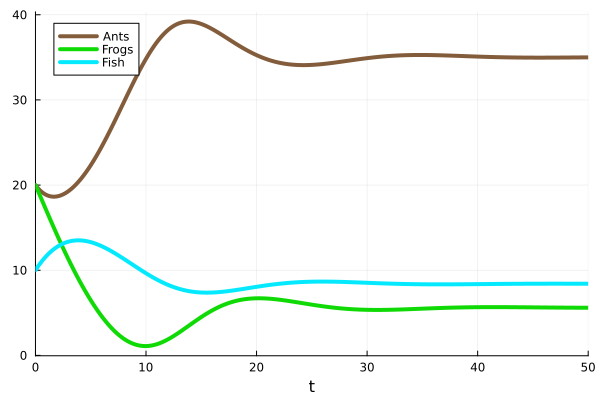

In [4]:
using DifferentialEquations 

## Colors for plotting
cc = ["#835C3B" "#10DA05" "#05E9FF"] 

## Parameters [α₁ α₂ δ₁ δ₂ δ₃]
par  = (:α₁ => 0.2, :α₂ => 0.15, :δ₁ => 0.05, :δ₂ => 0.15, :δ₃ =>0.1)

## Initial conditions
u₀ = [:🐜 =>20., :🐸=>20., :🐟=>10.]

## time span for simulation 
tspan = (0., 50.) 

## create the ODE system
ds = ODEProblem(ecomodel, u₀, tspan, par)  

sol = solve(ds, Tsit5()) 

plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"])

## Even simpler example of Catalyst.jl for getting started 

In [6]:
simplemodel = @reaction_network begin
    k₁, x --> y
    k₂, y --> z
end

pmap = (:k₁ => 1.0, :k₂ => 2.0)

reactions(simplemodel)

2-element Vector{Reaction}:
 k₁, x --> y
 k₂, y --> z

In [7]:
rn = complete(simplemodel)
odesys = convert(ODESystem, rn) 

u₀map = [:x => 10., :y => 0., :z => 0.]



3-element Vector{Pair{Symbol, Float64}}:
 :x => 10.0
 :y => 0.0
 :z => 0.0

In [8]:
# time interval to solve on
tspan = (0., 10.)

# create the ODEProblem we want to solve
prob = ODEProblem(rn, u₀map, tspan, pmap)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 3-element Vector{Float64}:
 10.0
  0.0
  0.0

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


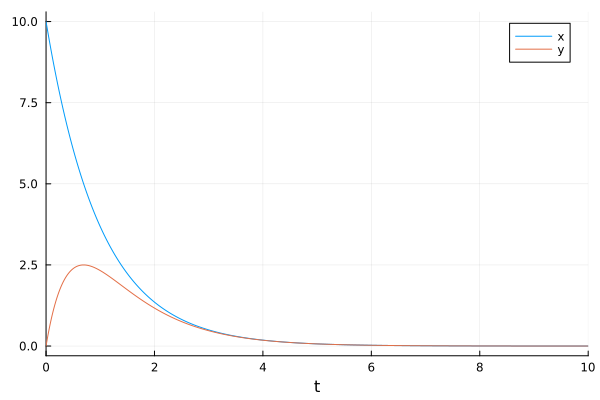

In [9]:
sol = solve(prob, Tsit5())
plot(sol, vars=(0,1)) 
plot!(sol, vars=(0,2))

### You can also define a diffeq model just using a function 

For more info see: https://docs.sciml.ai/DiffEqDocs/stable/getting_started/

In [10]:
function newecomodel!(du, u, p, t) 
    α₁, α₂, δ₁, δ₂, δ₃, g₁, g₂, g₃ = p 
    
    du[1] = α₁*u[1]*(1 - g₁*u[1] - g₂*u[2]) - α₂*u[1]*(1-0.1*u[3]) - δ₁*u[1]
    du[2] = α₂*u[1]*(1 - g₃*u[3]) - δ₂*u[2] 
    du[3] = δ₂*u[2] - δ₃*u[3] 
end


newecomodel! (generic function with 1 method)

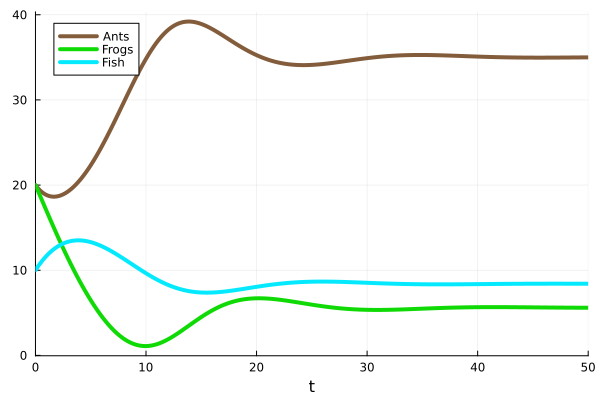

In [11]:
## Then define param and IC using array (not dict)

## Parameters [α₁ α₂ δ₁ δ₂ δ₃]
p = (0.2, 0.15, 0.05, 0.15, 0.1, 0.01, 0.05, 0.1)

## Initial conditions
u₀ = [20., 20., 10.]

## time span for simulation 
tspan = (0., 50.)

ds = ODEProblem(newecomodel!, u₀, tspan, p)
sol = solve(ds, Tsit5()) 

plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"]) 

#### Stochastic dynamics => updates to syntax required... 
https://docs.sciml.ai/Catalyst/stable/introduction_to_catalyst/introduction_to_catalyst/ 

To simulate a stochastic differential equation (SDE) model from the same reaction network, using the same inputs as for the ODE model, we can directly declare the model with no new definitions. NB we assume Brownian noise in this example, other noise models can be substituted (e.g. by modifying the $g$ of the SDE)

$$
 du = f(u,p,t)dt + g(u,p,t)dW.
$$

In [13]:
stoch_ds = SDEProblem(ecomodel, u₀, tspan, p) 

dt = 1//2^(4)
sol = solve(stoch_ds, EM(), dt=dt)
plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"])

ArgumentError: ArgumentError: The variable-value mapping must be a Dict.

To perform simulations of the discrete-time stochastic process associated with this reaction network, we can define a discrete problem and simulate it using SSA (Stochastic Simulation Algorithm), also known as the direct Gillespie algorithm.

In [14]:
ds_discrete = DiscreteProblem(ecomodel, [20,20,10], tspan, p)
jump_ds = JumpProblem(ecomodel, ds_discrete, Direct())

sol = solve(jump_ds, SSAStepper())
plot(sol, lw=4, lc=cc, labels=["Ants" "Frogs" "Fish"]) 

ArgumentError: ArgumentError: The variable-value mapping must be a Dict.

## Part 2: Steady states and their stability

Here we solve the ecological model defined above at steady state symbolically, and study the linear stability of its steady states via analysis of the Jacobian matrix.

In [15]:
## Using SymPy, we define the variables and parameters of the model
## and re-define the ODE system in terms of its RHS
🐜, 🐸, 🐟 = SymPy.@vars 🐜 🐸 🐟
α₁, α₂, δ₁, δ₂, δ₃, g₁, g₂, g₃ = SymPy.@vars α₁ α₂ δ₁ δ₂ δ₃ g₁ g₂ g₃

rhs = [α₁*🐜*(1 - g₁*🐜 - g₂*🐸) - α₂*🐜 - δ₁*🐜,
       α₂*🐜*(1 - g₃*🐟) - δ₂*🐸,
       δ₂*🐸 - δ₃*🐟]

fps = SymPy.solve(rhs, [🐜,🐸,🐟])

LoadError: LoadError: UndefVarError: `SymPy` not defined
in expression starting at c:\Users\lexis\USC Code\24-fall\qbio577\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X41sZmlsZQ==.jl:3

In [16]:
J = rhs.jacobian([🐜,🐸,🐟])

UndefVarError: UndefVarError: `rhs` not defined

Using the analytical solutions found for the steady states (fixed points) of the model and of its Jacobian, we can directly solve the Jacobian at a given fixed point in terms of the model parameters. (The solution is one that we would not want to derive by hand.)

In [17]:
## Select a fixed point
nfp = 2

## Substitute fixed point values
J_fp = J.subs([(🐜,fps[nfp][1]),(🐸,fps[nfp][2]),(🐟,fps[nfp][3])])

UndefVarError: UndefVarError: `J` not defined

Next, to analyze the linear stability of the fixed point at a point in parameter space, we substitute into the previous expression the chosen set of parameter values.

In [18]:
## Substitute parameter values 
par = [0.2, 0.5, 0.5, 0.1, 0.7, 0.1, 0.05, 0.02]
J_eval = J_fp.subs([(α₁,par[1]),(α₂,par[2]),(δ₁,par[3]),(δ₂,par[4]),(δ₃,par[5]),(g₁,par[6]),(g₂,par[7]),(g₃,par[8])])


UndefVarError: UndefVarError: `J_fp` not defined

Then the fixed point is stable at this point in parameter space if and only if all of the eigenvalues of the Jacobian have negative real part. Here we check whether this fixed point is stable:

In [19]:
## Calculate eigenvalues 
eigs = J_eval.eigenvals()

## Find the stability of the fixed point 
is_stable = false
if maximum(real(collect(keys(eigs)))) < 0
    is_stable = true
end
is_stable


UndefVarError: UndefVarError: `J_eval` not defined

## Part 3: Parameter inference with Turing.jl

Below is a demo of parameter inference of an ODE model. We use `Catalyst.jl` and `DifferentialEquations.jl` for model definitions and simulation, and `Turing.jl` for sampling and inference.

First, we simulate some data with added noise that we will use with which to fit the model. 

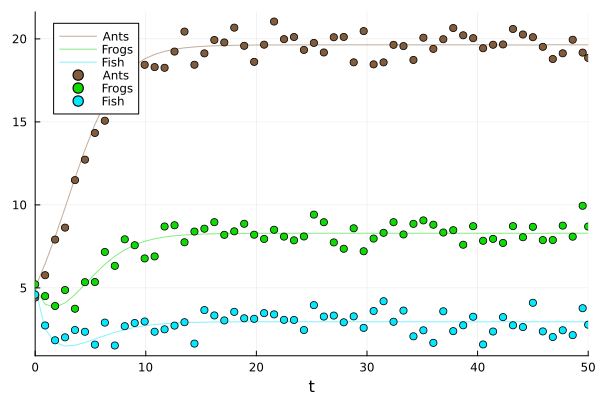

In [20]:
## Parameter inference
using Turing 
x0_inf = [5.; 5.; 5.]
p_inf = [0.8; 0.3; 0.1; 0.5; 1.4]
tspan = (0.0, 50.0)

ds = ODEProblem(ecomodel, x0_inf, tspan, p_inf)

sol = solve(ds,Tsit5(),saveat=.9)
targetdata = Array(sol) + 0.6*randn(size(Array(sol)))

plot(sol, alpha = 0.5, lc=cc, labels=["Ants" "Frogs" "Fish"]); scatter!(sol.t, targetdata', color=cc, labels=["Ants" "Frogs" "Fish"], legend=true)

Now define the model for inference. We use truncated Normal priors for each of the rate constants and an inverse Gamma distribution as the prior distribution over the noise $\sigma$. We run MCMC chain using NUTS in Turing.jl using a likelihood that samples from a Normal distribution where the simulated model defines the mean at each time point and the variance is $\sigma$.

In [21]:
@model function fitmodel(data, ds)
    σ ~ InverseGamma(2, 3) 
    α₁ ~ truncated(Normal(1.0,1.0),0,3)
    α₂ ~ truncated(Normal(1.0,1.0),0,3)
    δ₁ ~ truncated(Normal(1.0,1.0),0,3)
    δ₂ ~ truncated(Normal(1.0,1.0),0,3)
    δ₃ ~ truncated(Normal(1.0,1.0),0,3)

    p = [α₁,α₂,δ₁,δ₂,δ₃]
    prob = remake(ds, p=p)
    predicted = solve(prob,Tsit5(),saveat=.9)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitmodel(targetdata, ds)
@time chain = mapreduce(c -> sample(model, NUTS(.7), 1000), chainscat, 1:4)


Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference C:\Users\lexis\.julia\packages\Turing\Bv30p\src\mcmc\hmc.jl:212
Sampling   0%|█                                         |  ETA: 1:43:16
Sampling   1%|█                                         |  ETA: 0:51:31
Sampling   1%|█                                         |  ETA: 0:34:13
Sampling   2%|█                                         |  ETA: 0:25:33
Sampling   2%|█                                         |  ETA: 0:20:22
Sampling   3%|██                                        |  ETA: 0:16:55
Sampling   3%|██                                        |  ETA: 0:14:28
Sampling   4%|██                                        |  ETA: 0:12:40
Sampling   4%|██                                        |  ETA: 0:11:14
Sampling   5%|██                                        |  ETA: 0:10:06
Sampling   5%|███                                       |  ETA: 0:09:10
Sampl

We analyze the results of four independent chains by plotting their marginal density distributions.

In [ ]:
using StatsPlots
plot(chain)

In [ ]:
ds = ODEProblem(ecomodel, u₀, tspan, p)

